In [1]:
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', '{:.2g}'.format)

In [2]:
from sklearn_utils.utils import SkUtilsIO

X, y = SkUtilsIO('../outputs/bc_sampling_hist.json', gz=True).from_json()

In [5]:
from sklearn.pipeline import Pipeline
from metabolitics.preprocessing import MetaboliticsPipeline
from metabolitics_sampling import SamplingDiffTransformer


pipe_f = Pipeline([
    ('sampling-diff', SamplingDiffTransformer()),
    ('pathway-score', MetaboliticsPipeline([
         'feature-selection',
         'pathway_transformer'
    ]))
])

X_t_f = pipe_f.fit_transform(X, y)

In [6]:
import pandas as pd

from statsmodels.sandbox.stats.multicomp import multipletests
from sklearn.feature_selection import VarianceThreshold, f_classif

def variance_threshold_on_df(df: pd.DataFrame, threshold=0):
    vt = VarianceThreshold(threshold)
    vt.fit(df.values)
    return df.iloc[:, vt.variances_ > threshold]


def feature_importance_anova(X,
                             y,
                             threshold=0.001,
                             correcting_multiple_hypotesis=True,
                             method='fdr_bh',
                             alpha=0.1,
                             sort_by='pval'):
    '''
    Provide signifance for features in dataset with anova using multiple hypostesis testing
    :X: List of dict with key as feature names and values as features
    :y: Labels
    :threshold: Low-variens threshold to eliminate low varience features
    :correcting_multiple_hypotesis: corrects p-val with multiple hypotesis testing
    :method: method of multiple hypotesis testing
    :alpha: alpha of multiple hypotesis testing
    :sort_by: sorts output dataframe by pval or F
    :return: DataFrame with F and pval for each feature with their average values 
    '''
    df = variance_threshold_on_df(
        pd.DataFrame.from_records(X), threshold=threshold)

    F, pvals = f_classif(df.values, y)

    if correcting_multiple_hypotesis:
        _, pvals, _, _ = multipletests(pvals, alpha=alpha, method=method)

    df['labels'] = y
    df_mean = df.groupby('labels').mean().T

    df_mean['F'] = F
    df_mean['pval'] = pvals

    return df_mean.sort_values(sort_by, ascending=True)

In [7]:
df_f = feature_importance_anova(X_t_f,y)

In [8]:
df_f

labels,bc,healthy,F,pval
Alanine and aspartate metabolism,3.7,8.9e-16,2.1e+02,1.9e-32
Nucleotide interconversion,83,3.4e-14,1.5e+02,1.3e-24
Taurine and hypotaurine metabolism,8.9,4.1e-15,1.3e+02,5e-23
CoA synthesis,10,5.6e-15,93,1.5e-17
Eicosanoid metabolism,-0.94,-2.7e-16,85,1.7e-16
"Transport, lysosomal",11,5e-15,78,2.4e-15
Biotin metabolism,1.5,-1.5e-16,66,1.4e-13
Arginine and Proline Metabolism,49,5e-15,66,1.4e-13
Butanoate metabolism,-63,6.3e-14,59,2.3e-12
"Transport, nuclear",17,-2.8e-14,55,7.7e-12


In [9]:
df_f.shape

(31, 4)

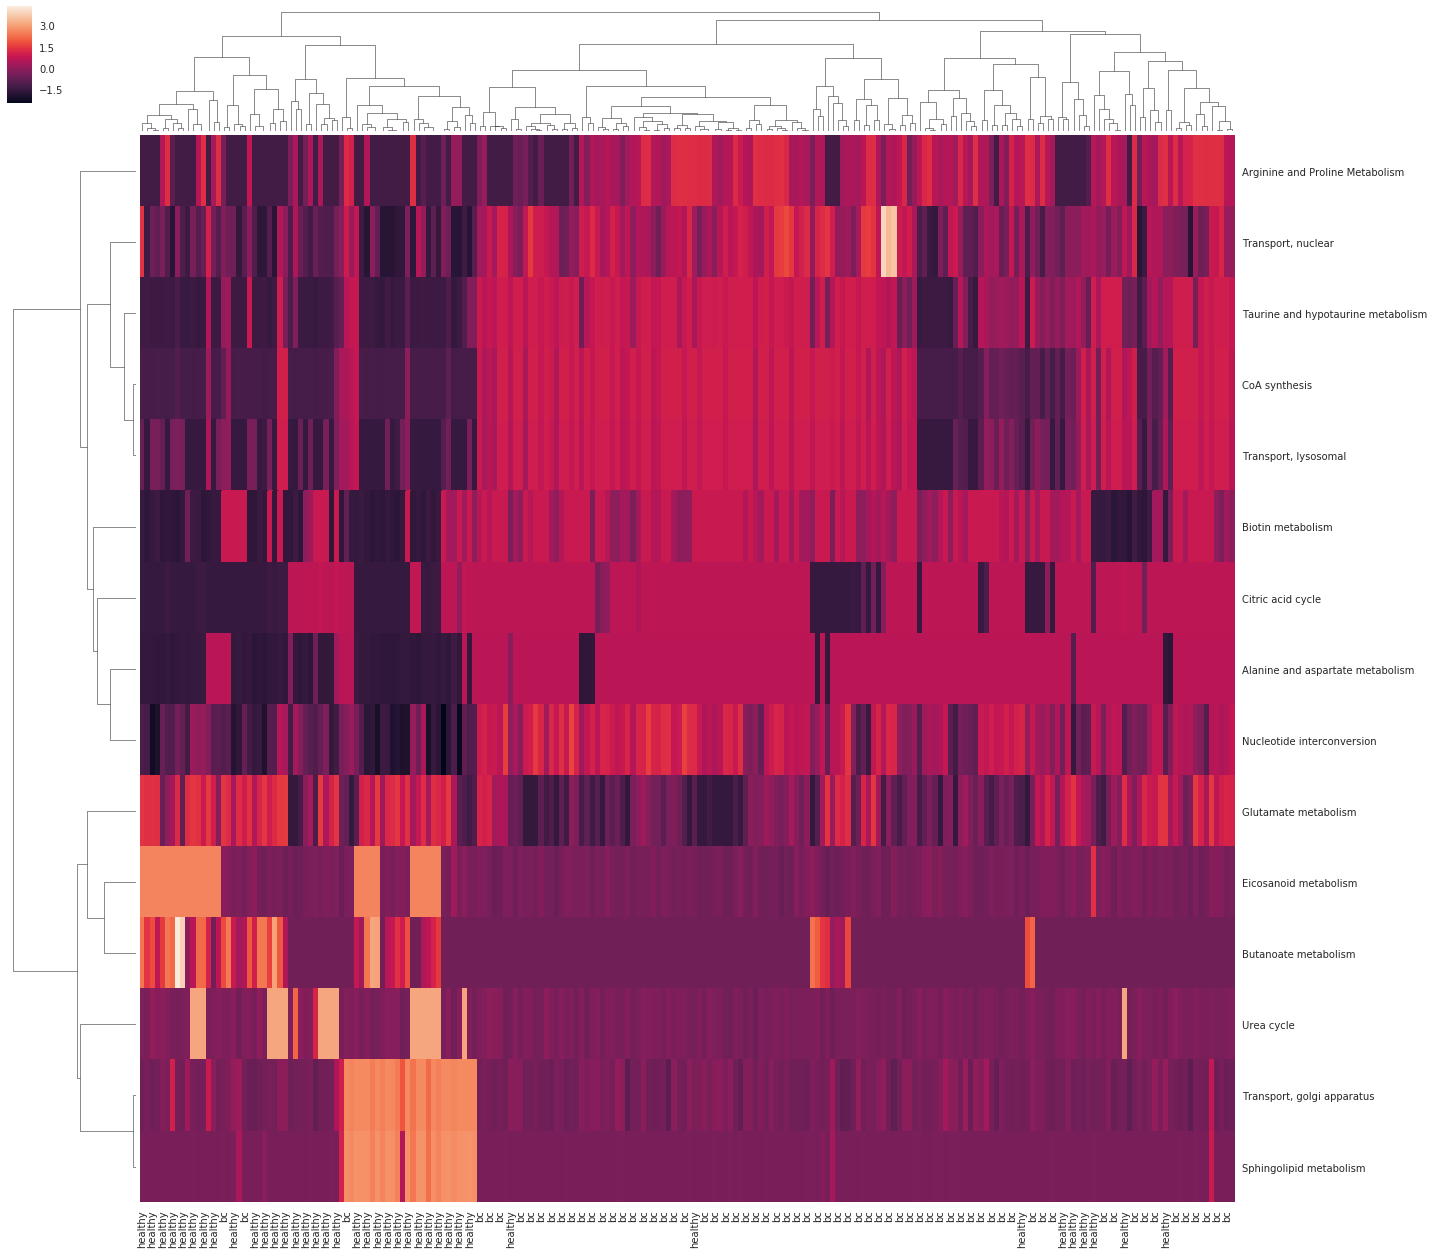

In [16]:
%matplotlib inline

from ipywidgets import interact

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.cluster.hierarchy import linkage

sns.set(color_codes=True)


@interact(
    top_n=(0, df_f.shape[0], 1), 
    scaler_type=['min-max', 'std'], 
    metric=['correlation', 'euclidean'], 
    method=['single', 'complete', 'average'])
def visualize(top_n=15, scaler_type='std', metric='correlation', method='complete'):

    if top_n:
        df_sns_f = pd.DataFrame().from_records(X_t_f)[df_f[:top_n].index]
    else:
        df_sns_f = pd.DataFrame().from_records(X_t_f)

    scaler = StandardScaler() if scaler_type == 'std' else MinMaxScaler((-1,1))
    df_sns_f[df_sns_f.columns] = scaler.fit_transform(df_sns_f[df_sns_f.columns])
    df_sns_f = df_sns_f.T

    df_sns_f.columns = y

    g = sns.clustermap(df_sns_f, figsize=(22, 22), metric=metric, method=method)

In [11]:
pipe = Pipeline([
    ('sampling-diff', SamplingDiffTransformer()),
    ('pathway-score', MetaboliticsPipeline([
         'pathway_transformer'
    ]))
])

X_t = pipe.fit_transform(X, y)

In [12]:
df = feature_importance_anova(X_t, y)

In [13]:
df

labels,bc,healthy,F,pval
Arginine and Proline Metabolism,11,4.7e-15,1e+02,4.5e-18
Butanoate metabolism,-23,1e-14,53,3.2e-10
Vitamin C metabolism,-5.4,2.2e-14,49,1.2e-09
Methionine and cysteine metabolism,3.1,-1.1e-15,37,1.6e-07
"Transport, golgi apparatus",-1,-7.7e-16,34,3.5e-07
Sphingolipid metabolism,-1.1,3.9e-15,33,4.4e-07
Aminosugar metabolism,-1.5,-5.8e-15,29,2.3e-06
Glycerophospholipid metabolism,-2.3,8e-15,29,2.3e-06
Histidine metabolism,-3.2,-3.4e-15,29,2.3e-06
Glutamate metabolism,-12,-8.3e-15,24,1.8e-05
